
Batch size: 8
Original: 0.412 ms
Optimized: 0.160 ms
Speedup: 2.58x

Batch size: 16
Original: 0.630 ms
Optimized: 0.177 ms
Speedup: 3.55x

Batch size: 32
Original: 0.484 ms
Optimized: 0.238 ms
Speedup: 2.03x

Batch size: 64
Original: 0.446 ms
Optimized: 0.166 ms
Speedup: 2.69x

Batch size: 128
Original: 0.496 ms
Optimized: 0.217 ms
Speedup: 2.28x

Batch size: 256
Original: 0.529 ms
Optimized: 0.207 ms
Speedup: 2.56x

Batch size: 512
Original: 0.435 ms
Optimized: 0.196 ms
Speedup: 2.22x

Batch size: 1024
Original: 0.389 ms
Optimized: 0.181 ms
Speedup: 2.15x


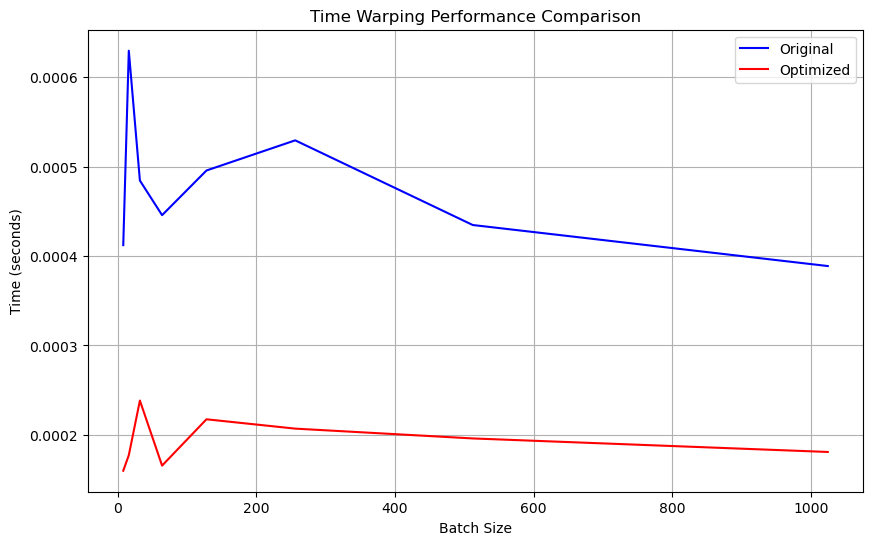

Correctness test passed!


True

In [2]:
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

# Original implementation
def warp_time_original(time_weights, u):
    normalized_weights = F.softmax(time_weights, dim=0)
    cumsum = torch.cumsum(normalized_weights, dim=0)
    
    u = torch.clamp(u, 0.0, 0.9999)
    num_segments = time_weights.shape[0]
    
    segment_idx = torch.searchsorted(cumsum, u)
    segment_idx = torch.clamp(segment_idx, 0, num_segments - 1)
    
    start_t = segment_idx.float() / num_segments
    end_t = (segment_idx.float() + 1) / num_segments
    
    prev_cumsum = torch.zeros_like(u)
    prev_cumsum = torch.where(segment_idx > 0, 
                            cumsum[segment_idx - 1], 
                            prev_cumsum)
    
    segment_u = (u - prev_cumsum) / normalized_weights[segment_idx]
    t = start_t + segment_u * (end_t - start_t)
    
    return torch.clamp(t, 0.0, 1.0)

# Optimized implementation
class WarpTimeOptimized:
    def __init__(self, time_weights):
        self.time_weights = time_weights
        self.num_segments = time_weights.shape[0]
        self._cached_norm_weights = None
        self._update_cache()
        
    def _update_cache(self):
        self._cached_norm_weights = F.softmax(self.time_weights, dim=0)
        self._cached_cumsum = torch.cumsum(self._cached_norm_weights, dim=0)
        self._cached_cumsum_padded = torch.cat([torch.zeros(1, device=self._cached_cumsum.device), 
                                              self._cached_cumsum])
    
    def warp_time(self, u):
        u = u.clamp(0.0, 0.9999)
        segment_idx = torch.searchsorted(self._cached_cumsum, u).clamp(0, self.num_segments - 1)
        t = (segment_idx + (u - self._cached_cumsum_padded[segment_idx]) / 
             self._cached_norm_weights[segment_idx]) / self.num_segments
        return t.clamp(0.0, 1.0)

def run_benchmark(batch_sizes, num_runs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_segments = 32
    time_weights = torch.ones(num_segments, device=device)
    
    original_times = []
    optimized_times = []
    
    optimized_warper = WarpTimeOptimized(time_weights)
    
    for batch_size in batch_sizes:
        # Warm up
        for _ in range(10):
            u = torch.rand(batch_size, device=device)
            _ = warp_time_original(time_weights, u)
            _ = optimized_warper.warp_time(u)
        
        # Original implementation timing
        original_total = 0
        for _ in range(num_runs):
            u = torch.rand(batch_size, device=device)
            start = time.perf_counter()
            _ = warp_time_original(time_weights, u)
            original_total += time.perf_counter() - start
        original_times.append(original_total / num_runs)
        
        # Optimized implementation timing
        optimized_total = 0
        for _ in range(num_runs):
            u = torch.rand(batch_size, device=device)
            start = time.perf_counter()
            _ = optimized_warper.warp_time(u)
            optimized_total += time.perf_counter() - start
        optimized_times.append(optimized_total / num_runs)
        
        print(f"\nBatch size: {batch_size}")
        print(f"Original: {original_total/num_runs*1000:.3f} ms")
        print(f"Optimized: {optimized_total/num_runs*1000:.3f} ms")
        print(f"Speedup: {original_total/optimized_total:.2f}x")
    
    return original_times, optimized_times, batch_sizes

# Run benchmark
batch_sizes = [8,16,32, 64, 128, 256, 512, 1024]
original_times, optimized_times, batch_sizes = run_benchmark(batch_sizes)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, original_times, 'b-', label='Original')
plt.plot(batch_sizes, optimized_times, 'r-', label='Optimized')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Time Warping Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Test correctness
def test_correctness():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    time_weights = torch.ones(32, device=device)
    optimized_warper = WarpTimeOptimized(time_weights)
    
    for _ in range(100):
        u = torch.rand(128, device=device)
        original_result = warp_time_original(time_weights, u)
        optimized_result = optimized_warper.warp_time(u)
        
        max_diff = torch.max(torch.abs(original_result - optimized_result))
        if max_diff > 1e-6:
            print(f"Warning: Results differ by {max_diff}")
            return False
    
    print("Correctness test passed!")
    return True

test_correctness()


Batch size: 8
Original: 0.026 ms
JIT: 0.032 ms
Speedup: 0.80x

Batch size: 16
Original: 0.034 ms
JIT: 0.031 ms
Speedup: 1.09x

Batch size: 32
Original: 0.041 ms
JIT: 0.046 ms
Speedup: 0.90x

Batch size: 64
Original: 0.044 ms
JIT: 0.064 ms
Speedup: 0.68x

Batch size: 128
Original: 0.050 ms
JIT: 0.030 ms
Speedup: 1.69x

Batch size: 256
Original: 0.069 ms
JIT: 0.064 ms
Speedup: 1.08x

Batch size: 512
Original: 0.060 ms
JIT: 0.073 ms
Speedup: 0.82x

Batch size: 1024
Original: 0.208 ms
JIT: 0.138 ms
Speedup: 1.51x


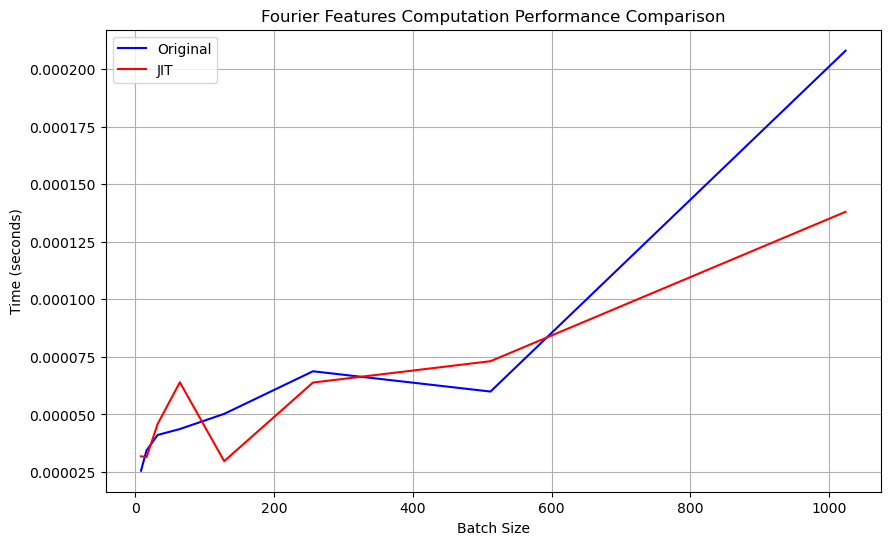

Fourier features correctness test passed!


True

In [5]:
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import numpy as np

# Force CPU usage
device = torch.device('cpu')

# Original model methods for comparison
def get_fourier_features_original(t, random_matrix):
    t_proj = t.unsqueeze(-1) @ random_matrix
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)

# JIT optimized version
@torch.jit.script
def get_fourier_features_jit(t, random_matrix):
    t_proj = t.unsqueeze(-1) @ random_matrix
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)

def benchmark_fourier_features(batch_sizes, num_runs=100):
    num_fourier_features = 4
    random_matrix = torch.randn(1, num_fourier_features) * 2 * np.pi
    
    original_times = []
    jit_times = []
    
    for batch_size in batch_sizes:
        # Warm up
        t = torch.rand(batch_size)
        for _ in range(10):
            _ = get_fourier_features_original(t, random_matrix)
            _ = get_fourier_features_jit(t, random_matrix)
            
        # Original timing
        original_total = 0
        for _ in range(num_runs):
            t = torch.rand(batch_size)
            start = time.perf_counter()
            _ = get_fourier_features_original(t, random_matrix)
            original_total += time.perf_counter() - start
        original_times.append(original_total / num_runs)
        
        # JIT timing
        jit_total = 0
        for _ in range(num_runs):
            t = torch.rand(batch_size)
            start = time.perf_counter()
            _ = get_fourier_features_jit(t, random_matrix)
            jit_total += time.perf_counter() - start
        jit_times.append(jit_total / num_runs)
        
        print(f"\nBatch size: {batch_size}")
        print(f"Original: {original_total/num_runs*1000:.3f} ms")
        print(f"JIT: {jit_total/num_runs*1000:.3f} ms")
        print(f"Speedup: {original_total/jit_total:.2f}x")
    
    return original_times, jit_times

# Test correctness
def test_fourier_correctness():
    num_fourier_features = 4
    random_matrix = torch.randn(1, num_fourier_features) * 2 * np.pi
    
    for batch_size in [32, 64, 128]:
        t = torch.rand(batch_size)
        original_result = get_fourier_features_original(t, random_matrix)
        jit_result = get_fourier_features_jit(t, random_matrix)
        
        max_diff = torch.max(torch.abs(original_result - jit_result))
        if max_diff > 1e-6:
            print(f"Warning: Results differ by {max_diff}")
            return False
    
    print("Fourier features correctness test passed!")
    return True

# Run benchmarks
batch_sizes = [8,16,32, 64, 128, 256, 512, 1024]
original_times, jit_times = benchmark_fourier_features(batch_sizes)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, original_times, 'b-', label='Original')
plt.plot(batch_sizes, jit_times, 'r-', label='JIT')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Fourier Features Computation Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

test_fourier_correctness()


Batch size: 8
Original: 0.069 ms
JIT: 0.100 ms
Speedup: 0.69x

Batch size: 16
Original: 0.101 ms
JIT: 0.088 ms
Speedup: 1.14x

Batch size: 32
Original: 0.169 ms
JIT: 0.168 ms
Speedup: 1.01x

Batch size: 64
Original: 0.297 ms
JIT: 0.262 ms
Speedup: 1.13x

Batch size: 128
Original: 1.360 ms
JIT: 1.276 ms
Speedup: 1.07x

Batch size: 256
Original: 5.406 ms
JIT: 5.135 ms
Speedup: 1.05x


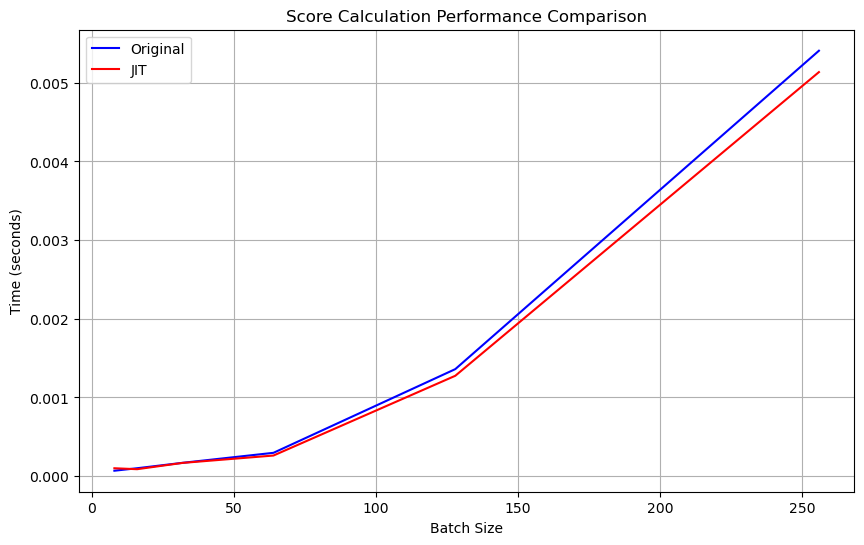

In [9]:
import torch
import time
import matplotlib.pyplot as plt

# Original version
def calculate_score_original(x, expected_x0, t):
    return (expected_x0 - x)/(t[:, None, None]**2)

# JIT version
@torch.jit.script
def calculate_score_jit(x, expected_x0, t):
    return (expected_x0 - x)/(t[:, None, None]**2)

def benchmark_score_calculation(batch_sizes, seq_len=32, embed_dim=512, num_runs=100):
    device = torch.device('cpu')  # Using CPU for now
    
    original_times = []
    jit_times = []
    
    for batch_size in batch_sizes:
        # Create test data
        x = torch.randn(batch_size, seq_len, embed_dim)
        expected_x0 = torch.randn(batch_size, seq_len, embed_dim)
        t = torch.rand(batch_size)
        
        # Warm up
        for _ in range(10):
            _ = calculate_score_original(x, expected_x0, t)
            _ = calculate_score_jit(x, expected_x0, t)
        
        # Original timing
        original_total = 0
        for _ in range(num_runs):
            start = time.perf_counter()
            _ = calculate_score_original(x, expected_x0, t)
            original_total += time.perf_counter() - start
        original_times.append(original_total / num_runs)
        
        # JIT timing
        jit_total = 0
        for _ in range(num_runs):
            start = time.perf_counter()
            _ = calculate_score_jit(x, expected_x0, t)
            jit_total += time.perf_counter() - start
        jit_times.append(jit_total / num_runs)
        
        print(f"\nBatch size: {batch_size}")
        print(f"Original: {original_total/num_runs*1000:.3f} ms")
        print(f"JIT: {jit_total/num_runs*1000:.3f} ms")
        print(f"Speedup: {original_total/jit_total:.2f}x")
    
    return original_times, jit_times

# Run benchmarks
batch_sizes = [8,16,32, 64, 128, 256]
original_times, jit_times = benchmark_score_calculation(batch_sizes)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, original_times, 'b-', label='Original')
plt.plot(batch_sizes, jit_times, 'r-', label='JIT')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Score Calculation Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()


Batch size: 8
Einsum: 7.380 ms
Matmul: 5.258 ms
Speedup: 1.40x

Batch size: 16
Einsum: 15.367 ms
Matmul: 12.880 ms
Speedup: 1.19x

Batch size: 32
Einsum: 18.410 ms
Matmul: 15.455 ms
Speedup: 1.19x

Batch size: 64
Einsum: 49.654 ms
Matmul: 40.871 ms
Speedup: 1.21x

Batch size: 128
Einsum: 77.838 ms
Matmul: 65.032 ms
Speedup: 1.20x


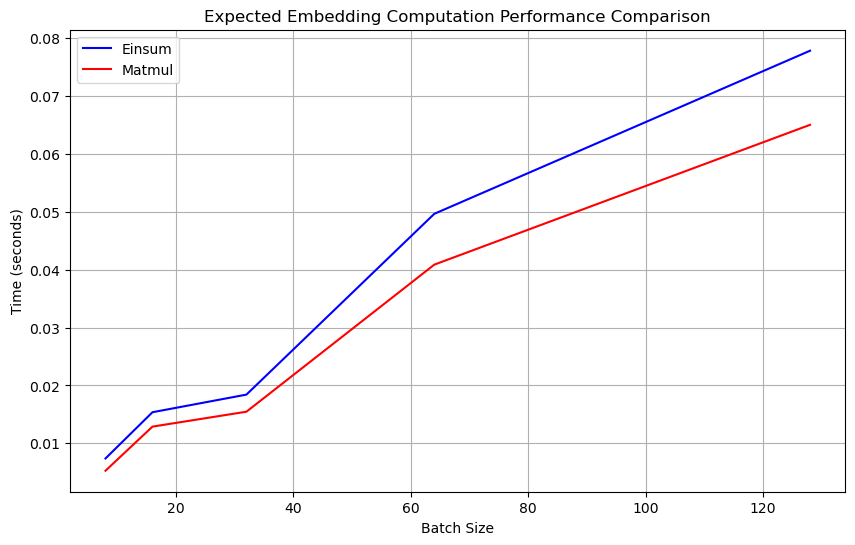

Maximum difference between implementations: 0.0


tensor(True, device='cuda:0')

In [10]:
import torch
import time
import matplotlib.pyplot as plt

def get_expected_embedding_einsum(logits, embeddings):
    probs = torch.softmax(logits, dim=-1)[:, :, 1:]
    all_embeddings = embeddings[1:]
    expected_embedding = torch.einsum('bsv,ve->bse', probs, all_embeddings)
    return expected_embedding

def get_expected_embedding_matmul(logits, embeddings):
    probs = torch.softmax(logits, dim=-1)[:, :, 1:]
    all_embeddings = embeddings[1:]
    expected_embedding = probs @ all_embeddings
    return expected_embedding

def benchmark_expected_embedding(batch_sizes, seq_len=32, vocab_size=32000, embed_dim=512, num_runs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    einsum_times = []
    matmul_times = []
    
    for batch_size in batch_sizes:
        # Create test data
        logits = torch.randn(batch_size, seq_len, vocab_size, device=device)
        embeddings = torch.randn(vocab_size, embed_dim, device=device)
        
        # Warm up
        for _ in range(10):
            _ = get_expected_embedding_einsum(logits, embeddings)
            _ = get_expected_embedding_matmul(logits, embeddings)
        
        # Time einsum version
        einsum_total = 0
        for _ in range(num_runs):
            start = time.perf_counter()
            _ = get_expected_embedding_einsum(logits, embeddings)
            torch.cuda.synchronize()  # Ensure GPU operations complete
            einsum_total += time.perf_counter() - start
        einsum_times.append(einsum_total / num_runs)
        
        # Time matmul version
        matmul_total = 0
        for _ in range(num_runs):
            start = time.perf_counter()
            _ = get_expected_embedding_matmul(logits, embeddings)
            torch.cuda.synchronize()  # Ensure GPU operations complete
            matmul_total += time.perf_counter() - start
        matmul_times.append(matmul_total / num_runs)
        
        print(f"\nBatch size: {batch_size}")
        print(f"Einsum: {einsum_total/num_runs*1000:.3f} ms")
        print(f"Matmul: {matmul_total/num_runs*1000:.3f} ms")
        print(f"Speedup: {einsum_total/matmul_total:.2f}x")
    
    return einsum_times, matmul_times

def test_correctness():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size, seq_len, vocab_size, embed_dim = 32, 32, 32000, 512
    
    logits = torch.randn(batch_size, seq_len, vocab_size, device=device)
    embeddings = torch.randn(vocab_size, embed_dim, device=device)
    
    einsum_result = get_expected_embedding_einsum(logits, embeddings)
    matmul_result = get_expected_embedding_matmul(logits, embeddings)
    
    max_diff = torch.max(torch.abs(einsum_result - matmul_result))
    print(f"Maximum difference between implementations: {max_diff}")
    
    return max_diff < 1e-5

# Run benchmarks
batch_sizes = [8, 16, 32, 64, 128]
einsum_times, matmul_times = benchmark_expected_embedding(batch_sizes)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, einsum_times, 'b-', label='Einsum')
plt.plot(batch_sizes, matmul_times, 'r-', label='Matmul')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Expected Embedding Computation Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Test correctness
test_correctness()


Batch size: 8
Original: 0.670 ms
Combined: 0.694 ms
Speedup: 0.96x

Batch size: 16
Original: 0.682 ms
Combined: 0.627 ms
Speedup: 1.09x

Batch size: 32
Original: 0.584 ms
Combined: 0.621 ms
Speedup: 0.94x

Batch size: 64
Original: 0.705 ms
Combined: 0.727 ms
Speedup: 0.97x

Batch size: 128
Original: 0.726 ms
Combined: 0.708 ms
Speedup: 1.03x


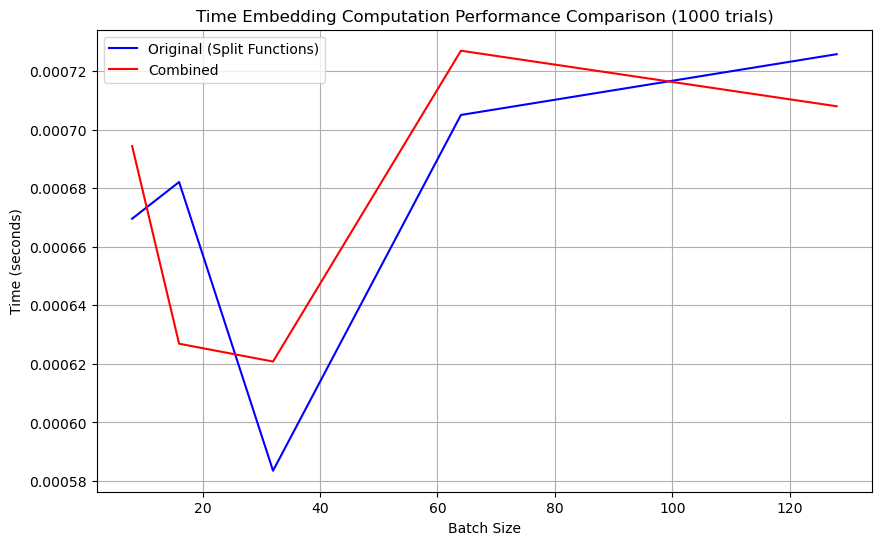

Maximum difference between implementations: 0.0


True

In [15]:
import torch
import time
import matplotlib.pyplot as plt

# Current version - split into two functions
def get_fourier_features_original(t, random_matrix):
    t_proj = t.unsqueeze(-1) @ random_matrix
    fourier_features = torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)
    return fourier_features

def get_time_embedding_original(t, random_matrix, time_mlp):
    fourier_features = get_fourier_features_original(t, random_matrix)
    return time_mlp(fourier_features)

# Combined version
def get_time_embedding_combined(t, random_matrix, time_mlp):
    t_proj = t.unsqueeze(-1) @ random_matrix
    fourier_features = torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)
    return time_mlp(fourier_features)

def benchmark_time_embedding(batch_sizes, embed_dim=512, num_fourier_features=4, num_runs=1000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    time_mlp = torch.nn.Sequential(
        torch.nn.Linear(2 * num_fourier_features, embed_dim),
        torch.nn.GELU(),
        torch.nn.Linear(embed_dim, embed_dim),
        torch.nn.GELU()
    ).to(device)
    
    random_matrix = (torch.randn(1, num_fourier_features, device=device) * 2 * torch.pi)
    
    original_times = []
    combined_times = []
    
    for batch_size in batch_sizes:
        t = torch.rand(batch_size, device=device)
        
        # Warm up
        for _ in range(50):  # Increased warm-up runs
            _ = get_time_embedding_original(t, random_matrix, time_mlp)
            _ = get_time_embedding_combined(t, random_matrix, time_mlp)
        
        # Time original version
        original_total = 0
        for _ in range(num_runs):
            start = time.perf_counter()
            _ = get_time_embedding_original(t, random_matrix, time_mlp)
            torch.cuda.synchronize()
            original_total += time.perf_counter() - start
        original_times.append(original_total / num_runs)
        
        # Time combined version
        combined_total = 0
        for _ in range(num_runs):
            start = time.perf_counter()
            _ = get_time_embedding_combined(t, random_matrix, time_mlp)
            torch.cuda.synchronize()
            combined_total += time.perf_counter() - start
        combined_times.append(combined_total / num_runs)
        
        print(f"\nBatch size: {batch_size}")
        print(f"Original: {original_total/num_runs*1000:.3f} ms")
        print(f"Combined: {combined_total/num_runs*1000:.3f} ms")
        print(f"Speedup: {original_total/combined_total:.2f}x")
    
    return original_times, combined_times

def test_correctness():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 32
    embed_dim = 512
    num_fourier_features = 4
    
    time_mlp = torch.nn.Sequential(
        torch.nn.Linear(2 * num_fourier_features, embed_dim),
        torch.nn.GELU(),
        torch.nn.Linear(embed_dim, embed_dim),
        torch.nn.GELU()
    ).to(device)
    
    random_matrix = (torch.randn(1, num_fourier_features, device=device) * 2 * torch.pi)
    t = torch.rand(batch_size, device=device)
    
    original_result = get_time_embedding_original(t, random_matrix, time_mlp)
    combined_result = get_time_embedding_combined(t, random_matrix, time_mlp)
    
    max_diff = torch.max(torch.abs(original_result - combined_result))
    print(f"Maximum difference between implementations: {max_diff}")
    
    return torch.allclose(original_result, combined_result)

# Run benchmarks
batch_sizes = [8, 16, 32, 64, 128]
original_times, combined_times = benchmark_time_embedding(batch_sizes)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, original_times, 'b-', label='Original (Split Functions)')
plt.plot(batch_sizes, combined_times, 'r-', label='Combined')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Time Embedding Computation Performance Comparison (1000 trials)')
plt.legend()
plt.grid(True)
plt.show()

# Test correctness
test_correctness()